### Load bankruptcy data from UCI :  5thYear.arff 
### Feature explanation: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
### The data contains financial rates from 5th year of the forecasting period and corresponding class label that indicates bankruptcy status after 1 year. The data contains 5910 instances (financial statements), 410 represents bankrupted companies, 5500 firms that did not bankrupt in the forecasting period.

### First, we build a logistic regression model to predict if bankrupt. The metrics we use is BER, which is the smaller the better. Because the dataset is imbalanced, we use class weight=’balanced’ to train the model.

In [1]:
import numpy as np
import pandas as pd
import math
import random
import warnings
#warnings.filterwarnings("ignore")
from sklearn.decomposition import  PCA
from sklearn import linear_model

f = open("week2 pca/5year.arff", 'r')
# Reading in data
while not '@data' in f.readline():
    pass
dataset = []
for l in f:
    if '?' in l: # Missing entry
        continue
    l = l.split(',')
    values = [1] + [float(x) for x in l]
    values[-1] = values[-1] > 0 # Convert to bool
    dataset.append(values)
    
X=[d[:-1] for d in dataset]
y=[d[-1] for d in dataset]


In [43]:
# Fit model
mod = linear_model.LogisticRegression(C=1.0,solver="liblinear",max_iter=5000)
mod.fit(X,y)
pred=mod.predict(X)
pred
# positive predictions
accuracy=sum(pred==y)/len(y)
print("the accuracy is", accuracy)

the accuracy is 0.9683272847245133


In [44]:
# BER
TP_=np.logical_and(pred,y)
TN_=np.logical_and(np.logical_not(pred),np.logical_not(y))
FP_=np.logical_and(pred,np.logical_not(y))
FN_=np.logical_and(np.logical_not(pred),y)
TP=sum(TP_)
TN=sum(TN_)
FN=sum(FN_)
FP=sum(FP_)

BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print("BER=",BER)

BER= 0.446931965001774


In [5]:
## split data

In [2]:
Xy=list(zip(X,y))
random.shuffle(Xy)

In [3]:
X=[d[0] for d in Xy]
y=[d[1] for d in Xy]
N=len(y)
ntrain=math.ceil(0.5*N)
nvalidation=math.ceil(0.25*N)
ntest=math.ceil(0.25*N)


In [4]:
xtrain=X[:ntrain]
xvali=X[ntrain:ntrain+nvalidation]
xtest=X[nvalidation+ntrain:]

ytrain=y[:ntrain]
yvali=y[ntrain:ntrain+nvalidation]
ytest=y[nvalidation+ntrain:]

# balance model class weight=’balanced’
def accuracy(x,y):
    bmodel= linear_model.LogisticRegression(C=1, class_weight='balanced',solver="lbfgs",max_iter=5000)
    bmodel.fit(xtrain,ytrain)
    pred_=bmodel.predict(x)
    accuracy=sum(pred_==y)/len(y)
    TP_=np.logical_and(pred_,y)
    TN_=np.logical_and(np.logical_not(pred_),np.logical_not(y))
    FP_=np.logical_and(pred_,np.logical_not(y))
    FN_=np.logical_and(np.logical_not(pred_),y)
    TP=sum(TP_)
    TN=sum(TN_)
    FN=sum(FN_)
    FP=sum(FP_)
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    return accuracy,BER


In [49]:
#np.array(xtrain).shape

In [58]:
print("train data accuracy:",accuracy(xtrain,ytrain)[0],"train data BER:",accuracy(xtrain,ytrain)[1])
print("validation data accuracy:",accuracy(xvali,yvali)[0],"validation data BER:",accuracy(xvali,yvali)[1])
print("test data accuracy:",accuracy(xtest,ytest)[0],"test data BER:",accuracy(xtest,ytest)[1])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


train data accuracy: 0.8027704485488126 train data BER: 0.20474921425778136


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


validation data accuracy: 0.8060686015831134 validation data BER: 0.20918933309668541


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


test data accuracy: 0.7859973579920739 test data BER: 0.19110959527057747


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Then, we try to find a regularization parameter C that minimize the BER.

In [62]:
def parameter(c,x,y):
    bmodel= linear_model.LogisticRegression(C=c, class_weight='balanced',solver="liblinear",max_iter=5000)
    bmodel.fit(xtrain,ytrain)
    pred_=bmodel.predict(x)
    accuracy=sum(pred_==y)/len(y)
    TP_=np.logical_and(pred_,y)
    TN_=np.logical_and(np.logical_not(pred_),np.logical_not(y))
    FP_=np.logical_and(pred_,np.logical_not(y))
    FN_=np.logical_and(np.logical_not(pred_),y)
    TP=sum(TP_)
    TN=sum(TN_)
    FN=sum(FN_)
    FP=sum(FP_)
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    return c,accuracy,BER
    

In [63]:
a=np.logspace(-4,4,9,base=10)
l_train=[]
l_vali=[]
l_test=[]

df_train = pd.DataFrame(columns=['parameter', 'train accuracy', 'train BER']) 
df_vali = pd.DataFrame(columns=['parameter', 'validation accuracy', 'validation BER']) 
df_test = pd.DataFrame(columns=['parameter', 'test accuracy', 'test BER']) 

for i in range(len(a)):
    p=parameter(a[i],xtrain,ytrain)
    l_train.append(p)
    l_train=list(l_train)
    
for i in range(len(a)):
    p=parameter(a[i],xvali,yvali)
    l_vali.append(p)
    l_vali=list(l_vali)

for i in range(len(a)):
    p=parameter(a[i],xtest,ytest)
    l_test.append(p)
    l_test=list(l_test)
 

In [64]:
for i in range(len(a)):
    df_train.loc[i,"parameter"]=l_train[i][0]
    df_train.loc[i,"train accuracy"]=l_train[i][1]
    df_train.loc[i,"train BER"]=l_train[i][2]

for i in range(len(a)):
    df_vali.loc[i,"parameter"]=l_vali[i][0]
    df_vali.loc[i,"validation accuracy"]=l_vali[i][1]
    df_vali.loc[i,"validation BER"]=l_vali[i][2]

for i in range(len(a)):
    df_test.loc[i,"parameter"]=l_test[i][0]
    df_test.loc[i,"test accuracy"]=l_test[i][1]
    df_test.loc[i,"test BER"]=l_test[i][2]



In [65]:
print(df_train)

print(df_vali)

print(df_test)

  parameter train accuracy train BER
0    0.0001       0.757916  0.269086
1     0.001        0.80409  0.224664
2      0.01       0.800792   0.20577
3       0.1       0.812005  0.189686
4         1       0.833113  0.147901
5        10       0.841689   0.12288
6       100       0.835752  0.136241
7      1000       0.833773  0.157858
8     10000       0.844327  0.121518
  parameter validation accuracy validation BER
0    0.0001            0.762533       0.231885
1     0.001            0.815303       0.173492
2      0.01            0.808707       0.176931
3       0.1             0.82058       0.139859
4         1            0.841689       0.159737
5        10            0.848285       0.156299
6       100            0.843008        0.15905
7      1000            0.841689       0.159737
8     10000            0.848285       0.140857
  parameter test accuracy  test BER
0    0.0001      0.725231   0.26279
1     0.001      0.778071  0.235505
2      0.01      0.787318   0.23073
3       0.1     

In [66]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'train accuracy')

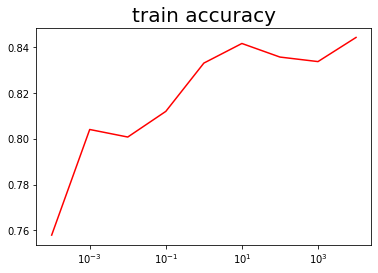

In [67]:
plt.semilogx(df_train['parameter'],df_train['train accuracy'],label="accuracy",color="red",lw=1.5)
plt.title('train accuracy',size=20)

Text(0.5, 1.0, 'train BER')

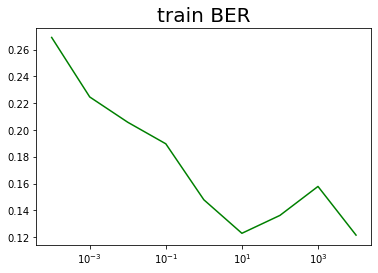

In [68]:
plt.semilogx(df_train['parameter'],df_train['train BER'],label="BER",color="green",lw=1.5)
plt.title('train BER',size=20)

Text(0.5, 1.0, 'vali accuracy')

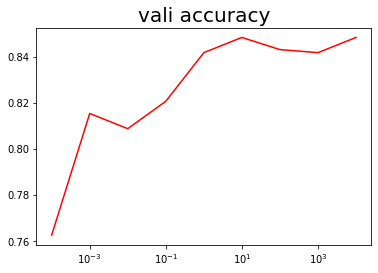

In [69]:
plt.semilogx(df_vali['parameter'],df_vali['validation accuracy'],label="accuracy",color="red")
plt.title('vali accuracy',size=20)

Text(0.5, 1.0, 'vali BER')

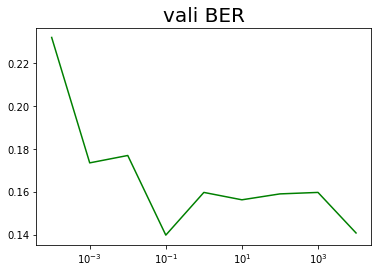

In [70]:
plt.semilogx(df_vali['parameter'],df_vali['validation BER'],label="BER",color="green")
plt.title('vali BER',size=20)

Text(0.5, 1.0, 'test accuracy')

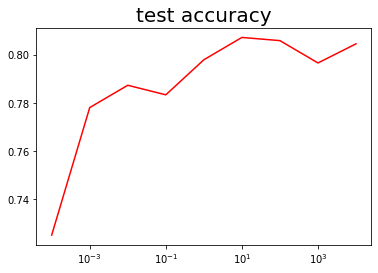

In [72]:
plt.semilogx(df_test['parameter'],df_test['test accuracy'],label="accuracy",color="red")
plt.title('test accuracy',size=20)

Text(0.5, 1.0, 'test BER')

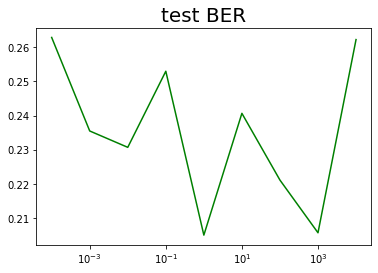

In [73]:
plt.semilogx(df_test['parameter'],df_test['test BER'],label="BER",color="green")
plt.title('test BER',size=20)

### Ok, we found parameter=0.1, validation BER is smallest.
### But what if we don't use balance weight? For example, we want to find out most bankrupted (y=1) companies because it is important when we make investment decisions. We don't want to take the risk that we invest on a bank that will go bankrupcy! So we can assign sample weight to labels to adjust their weight in our model.
### Let's see what's the best weight that can result in a higher F score, which balances the precison and recall rate and the larger the better.

In [83]:
# unweighted F1 & F10

unmod = linear_model.LogisticRegression(C=1, solver='lbfgs',max_iter=8000)
unmod.fit(xtrain,ytrain)
pred_=unmod.predict(xtest)

def fscore(pred_,ytest):
    TP_=np.logical_and(pred_,ytest)
    TN_=np.logical_and(np.logical_not(pred_),np.logical_not(ytest))
    FP_=np.logical_and(pred_,np.logical_not(ytest))
    FN_=np.logical_and(np.logical_not(pred_),ytest)
    TP=sum(TP_)
    TN=sum(TN_)
    FN=sum(FN_)
    FP=sum(FP_)
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    F1=2*P*R/(P+R)
    F10=101*P*R/(100*P+R)
    return F1,F10

fscore(pred_,ytest)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.06451612903225806, 0.04196094723722476)

In [84]:

import copy 
pred_result=[]
f_result=[]
for i in np.arange(0,6,0.5):
    weights=np.array(copy.copy(ytrain))*1
    weights[weights==1]=i
    weights[weights==0]=1
    mod=linear_model.LogisticRegression(C=1, solver='lbfgs',max_iter=8000)
    mod.fit(xtrain, ytrain, sample_weight=weights)
    pred_2=mod.predict(xtest)
    pred_result.append(pred_2)

for i in range(len(np.arange(0,6,0.5))):
    f=fscore(pred_result[i],ytest)
    f_result.append(f)

f_result

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[(0.06451612903225806, 0.04196094723722476),
 (0.06451612903225806, 0.04196094723722476),
 (0.06451612903225806, 0.04196094723722476),
 (0.06451612903225806, 0.04196094723722476),
 (0.06060606060606061, 0.04192611041926111),
 (0.06060606060606061, 0.04192611041926111),
 (0.10810810810810811, 0.08371322005801907),
 (0.10810810810810811, 0.08371322005801907),
 (0.186046511627907, 0.1670111616370401),
 (0.186046511627907, 0.1670111616370401),
 (0.1702127659574468, 0.16673545191910852),
 (0.1702127659574468, 0.16673545191910852)]

### Ok, we found that when weight>=3 ,both F1 and F10score are larger than those of unweighted (balanced) model.
### Next we’ll consider using PCA to build a lower-dimensional feature vector to do prediction.


In [5]:
pca=PCA()
pca.fit(xtrain)
print(pca.components_[0])

[-3.44741335e-19  2.06326747e-07 -9.78743126e-07  1.03551203e-06
  5.09931126e-06  4.56494818e-04  5.74104483e-07  2.36180788e-07
  6.19731033e-06 -5.14207638e-07  9.46953549e-07  1.92936641e-07
  1.12195322e-06  4.50956107e-07  2.36180788e-07 -2.53162640e-03
  1.15750481e-06  6.50436969e-06  2.36180788e-07  4.94885103e-07
  2.94006497e-05 -1.20076220e-05  1.70216247e-07  4.64977535e-07
  4.24008578e-07  1.14234787e-06  1.02011394e-06  3.75756302e-05
  3.04355207e-05  3.55693302e-06 -1.82409295e-06  4.78670311e-07
 -2.86360789e-04  5.02579263e-06 -1.58392014e-06  1.46663131e-07
 -5.60361595e-07  6.07307539e-04  7.56888555e-07  1.95314491e-07
  1.99904343e-06 -1.44972614e-06  4.20755091e-07  4.45855376e-05
  1.51842907e-05 -2.90322950e-06  3.73012913e-06  4.61987225e-05
  1.95420463e-07  4.63301710e-07  4.19900806e-06 -7.47500765e-07
 -7.43181370e-07  1.77639202e-06  3.05987889e-05  9.99996415e-01
  1.97126240e-07 -4.07855654e-07 -2.52300761e-07 -2.67730343e-07
 -1.35546127e-04 -1.54165

In [90]:
Xpca_train=[]
Xpca_valid=[]
Xpca_test=[]
pred_=[]
BER_vali=[]
TP_=[]
TN_=[]
FP_=[]
FN_=[]
TP=[]
TN=[]
FP=[]
FN=[]
pca=[]

for i in range(5,35,5): 
    pca.append(PCA(n_components=i))
for j in range(6):
    pca[j].fit(xtrain)
    Xpca_train.append(pca[j].transform(xtrain))
    Xpca_valid.append(pca[j].transform(xvali))
    Xpca_test.append(pca[j].transform(xtest))
    bmodel= linear_model.LogisticRegression(C=1, class_weight='balanced',solver="lbfgs",max_iter=8000)
    bmodel.fit(Xpca_train[j],ytrain)
    pred_.append(bmodel.predict(Xpca_valid[j]))
    TP_.append(np.logical_and(pred_[j],yvali))
    TN_.append(np.logical_and(np.logical_not(pred_[j]),np.logical_not(yvali)))
    FP_.append(np.logical_and(pred_[j],np.logical_not(yvali)))
    FN_.append(np.logical_and(np.logical_not(pred_[j]),yvali))
    TP.append(sum(TP_[j]))
    TN.append(sum(TN_[j]))
    FN.append(sum(FN_[j]))
    FP.append(sum(FP_[j]))
    Ber = 1 - 0.5 * (TP[j] / (TP[j] + FN[j]) + TN[j] / (TN[j] + FP[j]))
    BER_vali.append(Ber)
    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [91]:
BER_vali

[0.4712916537249856,
 0.34430048364911037,
 0.2054399432045082,
 0.23951723831920835,
 0.26671695434174914,
 0.19288281492656512]

In [92]:
BER_test=[]
Xpca_train=[]
Xpca_valid=[]
Xpca_test=[]
pred_=[]
TP_=[]
TN_=[]
FP_=[]
FN_=[]
TP=[]
TN=[]
FP=[]
FN=[]
for j in range(6):
    pca[j].fit(xtrain)
    Xpca_train.append(pca[j].transform(xtrain))
    Xpca_valid.append(pca[j].transform(xvali))
    Xpca_test.append(pca[j].transform(xtest))
    bmodel= linear_model.LogisticRegression(C=1, class_weight='balanced',solver="lbfgs",max_iter=8000)
    bmodel.fit(Xpca_train[j],ytrain)
    pred_.append(bmodel.predict(Xpca_test[j]))
    TP_.append(np.logical_and(pred_[j],ytest))
    TN_.append(np.logical_and(np.logical_not(pred_[j]),np.logical_not(ytest)))
    FP_.append(np.logical_and(pred_[j],np.logical_not(ytest)))
    FN_.append(np.logical_and(np.logical_not(pred_[j]),ytest))
    TP.append(sum(TP_[j]))
    TN.append(sum(TN_[j]))
    FN.append(sum(FN_[j]))
    FP.append(sum(FP_[j]))
    Ber = 1 - 0.5 * (TP[j] / (TP[j] + FN[j]) + TN[j] / (TN[j] + FP[j]))
    BER_test.append(Ber)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [93]:
BER_test

[0.41783196907685305,
 0.4149613460663939,
 0.24027967257844474,
 0.22180536607548884,
 0.24022282855843557,
 0.22379490677580716]

### There are 64 features and we use PCA to find the best number that we compress the features. The result showed that when N=30, that mean we reduce the 64 dimensions to 30 dimensions, validation BER is the minimn.